In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import time

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
data_dir = keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
                                fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['dandelion', 'tulips', 'sunflowers', 'daisy', 'roses'],
      dtype='<U10')

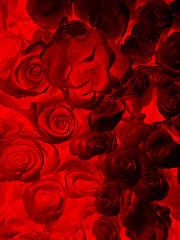

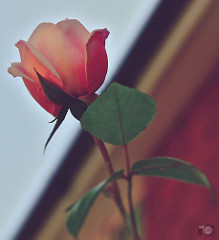

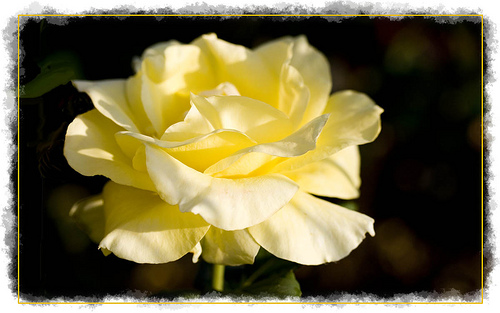

In [8]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

In [0]:
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [11]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')

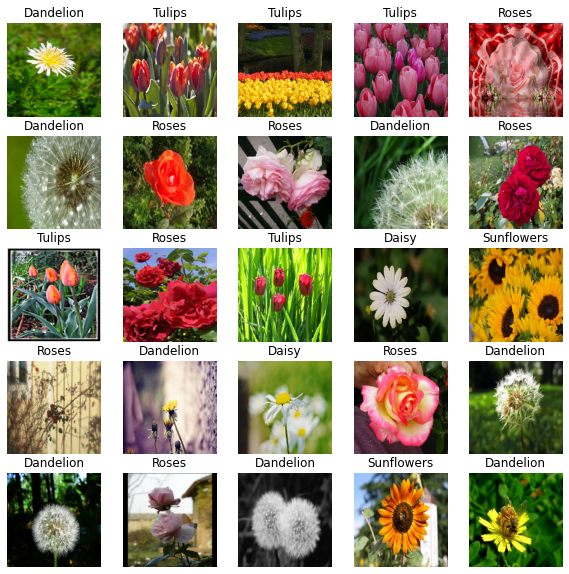

In [13]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [15]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/29972905_4cc537ff4b_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/14901528533_ac1ce09063.jpg'
b'/root/.keras/datasets/flower_photos/tulips/8695367666_0809529eaf_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/5598591979_ed9af1b3e9_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/4525067924_177ea3bfb4.jpg'


In [0]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in labeled_ds.take(1):
  print(f"Image shape: {image.numpy().shape}")
  print(f"Label: {label.numpy()}")

Image shape: (224, 224, 3)
Label: [False False False False  True]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  
  df = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  ds = ds.prefetch(AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

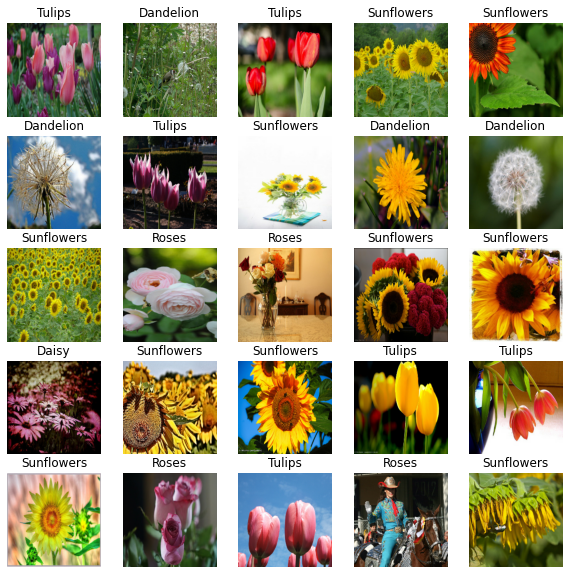

In [28]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.', end='')
  print()
  end = time.time()

  duration = end-start
  print(f"{steps} batches: {duration} s")
  print(f"{BATCH_SIZE*steps/duration} Images/s")

In [34]:
timeit(train_data_gen)

....................................................................................................
1000 batches: 91.61590003967285 s
349.2843489628208 Images/s


In [35]:
timeit(train_ds)

....................................................................................................
1000 batches: 13.074161052703857 s
2447.5757848632365 Images/s


In [36]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 61.335145711898804 s
521.7237136813733 Images/s


In [37]:
filecache_ds = prepare_for_training(labeled_ds, cache='./flowers.tfcache')
timeit(filecache_ds)

....................................................................................................
1000 batches: 36.29219722747803 s
881.7322301933193 Images/s
